In [1]:
from bs4 import BeautifulSoup
import urllib
import pandas as pd
import time
import math
import os
import numpy as np

# Scrape data

In [2]:
def parse_html_table(table):
    n_columns = 0
    n_rows=0
    column_names = []
    for row in table.find_all('tr'):

        td_tags = row.find_all('td')
        if len(td_tags) > 0:
            n_rows+=1
            if n_columns == 0:
                n_columns = len(td_tags)
        th_tags = row.find_all('th') 
        if len(th_tags) > 0 and len(column_names) == 0:
            for th in th_tags:
                column_names.append(th.get_text())

    if len(column_names) > 0 and len(column_names) != n_columns:
        df = pd.DataFrame()
        return df
        #raise Exception("Column titles do not match the number of columns")

    columns = column_names if len(column_names) > 0 else range(0,n_columns)
    df = pd.DataFrame(columns = columns,
                      index= range(0,n_rows))
    row_marker = 0
    for row in table.find_all('tr'):
        column_marker = 0
        columns = row.find_all('td')
        for column in columns:
            df.iat[row_marker,column_marker] = column.get_text()
            column_marker += 1
        if len(columns) > 0:
            row_marker += 1

    for col in df:
        try:
            df[col] = df[col].astype(float)
        except ValueError:
            pass

    return df

In [3]:
def PageToCsv(url,resort,year,TargetFolder):
    page = urllib.request.urlopen(url)
    soup = BeautifulSoup(page, "lxml")
    table = soup.find('div', attrs={'class': 'resortList'})
    df = parse_html_table(table=table)
    if df.empty:
        path = math.nan
        return path
    NumHeaders =['24 hr New Snow','Season Snowfall Total','Base Depth']
    for i in NumHeaders:df[i] = df[i].str.extract('(\d+)',expand=True).astype(int)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    try: 
        df.set_index('Date', drop=True, append=False, inplace=True, verify_integrity=True)
    except:
        df=df
    path = TargetFolder + os.sep + resort + '_' + year +'.csv'
    df.to_csv(path)
    
    return path

In [18]:
url = 'https://www.onthesnow.co.uk/france/statistics.html'
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")
table = soup.find('div', attrs={'class': 'resScrollCol8'})
resort = table.find_all('div', attrs={'class': 'name'})

ResortIndex = pd.DataFrame(columns=['title','link'])
for a in table.find_all('a'):
    try:
        link = a['href']
        title = a['title']
        title =title.replace('/', '_')
        title = title.replace('\\', '_')
        
        slCount = link.count('/')
        if ('reviews' not in title.lower()) and slCount ==3:
            link = link[:-15]
            
            
            ResortIndex.loc[len(ResortIndex)] = [title,link]
    except:
        link = ''
        title = ''


In [ ]:
years=['2017','2016','2015','2014','2013','2012','2011','2010','2009']

baseurl='https://www.onthesnow.co.uk'
#resortpath = ResortIndex.iloc[0,1]
#resort = ResortIndex.iloc[0,0]
midurl = 'historical-snowfall.html?&y='
endurl= '&v=list#view'
TargetFolder = 'Data'

colnames = ['resort','link'] + years
SnowData = pd.DataFrame(columns = colnames)
SnowData = SnowData.reset_index(drop=True)

for index, row in ResortIndex.iterrows():
    link = ResortIndex.iloc[index,1]
    resort = ResortIndex.iloc[index,0]

    entry = [resort,link]
    for j in years:
        #print(j)
        #print(url)
        url = baseurl + link + midurl +j + endurl
        path = PageToCsv(url,resort,j,TargetFolder)
        #print(path)
        #print('...')
        entry.append(path)
        time.sleep(1)
    SnowData.loc[len(SnowData)] = entry
SnowData.to_csv('SnowData Index.csv')

# Clean data

In [2]:
import sys
sys._enablelegacywindowsfsencoding() # To deal with french accents in filenames

SnowData = pd.read_csv('SnowDataIndex.csv',encoding='latin',index_col=0)
SnowData = SnowData.dropna(axis=0)
SnowData = SnowData.reset_index(drop=True)


In [3]:
Data = pd.DataFrame()
limitperiod = 1 #threshold period to interpolate between
Resorts_BaseDepth = pd.DataFrame()
Resorts_NewSnow = pd.DataFrame()
ResortNames = []
for index, col in SnowData.iterrows():
    ResortNames.append(SnowData.iloc[index,0])

    for i in range(10,1,-1):
        dsource = SnowData.iloc[index,i]
        #print(dsource)
        with open(dsource, 'r') as fp:
            Data = Data.append(pd.read_csv(fp, encoding = "utf-8",index_col=0))
        Data.drop(labels=['Season Snowfall Total'],axis=1)
        Data = Data.append(pd.read_csv(dsource,index_col=0))
    #splitinto base depth and new snowfall dataframes
    #resample weekly and fill basedepth gaps within reason through linear interpolation
    Data= Data.drop(labels=['Season Snowfall Total'],axis=1)
    Data.index = pd.to_datetime(Data.index, errors='coerce')
    Base_Depth = Data['Base Depth'].resample('M').mean()
    #Base_Depth.interpolate(method='linear', axis=0, limit=limitperiod, inplace=True)
    Base_Depth=Base_Depth.fillna(0)
    New_Snow = Data['24 hr New Snow'].resample('M').sum().fillna(0)
    Resorts_BaseDepth = pd.concat([Resorts_BaseDepth, Base_Depth], axis=1)
    Resorts_NewSnow = pd.concat([Resorts_NewSnow, New_Snow], axis=1)
Resorts_BaseDepth.columns = ResortNames
Resorts_NewSnow.columns = ResortNames
Resorts_BaseDepth=Resorts_BaseDepth.fillna(0)
Resorts_NewSnow=Resorts_NewSnow.fillna(0)


In [4]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.context('ggplot')

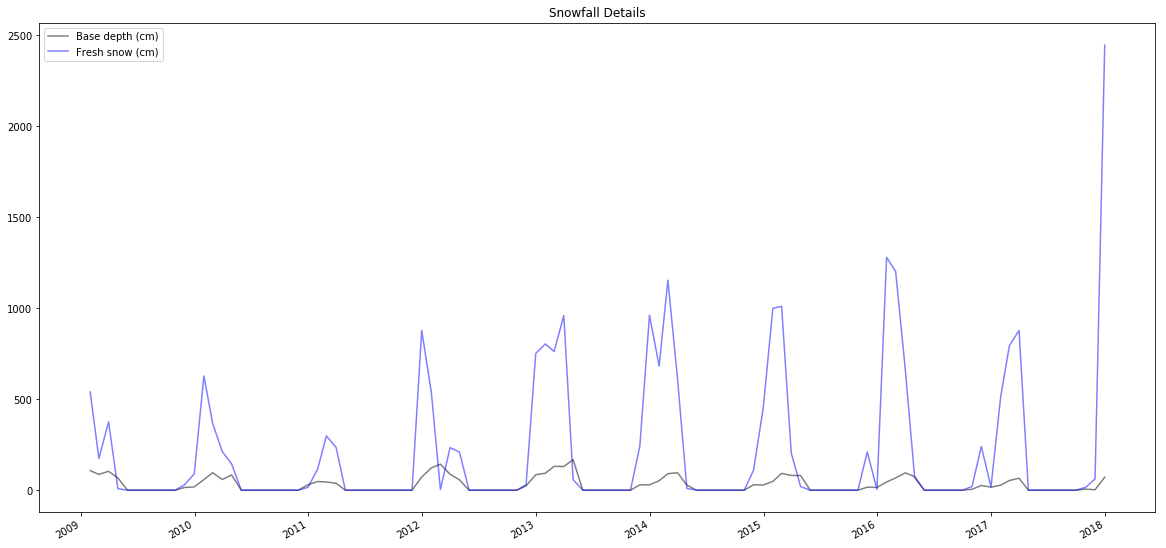

In [5]:
def PlotTimeSeries_SingleResort(basedepth,newsnow):

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(basedepth, color ='black',label='Base depth (cm)',alpha=0.5)
    ax.plot(newsnow, color ='blue',label='Fresh snow (cm)',alpha=0.5)


    fig.autofmt_xdate()

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.title('Snowfall Details')
    plt.legend()
    plt.show()

PlotTimeSeries_SingleResort(Resorts_BaseDepth.iloc[:,6],Resorts_NewSnow.iloc[:,6])


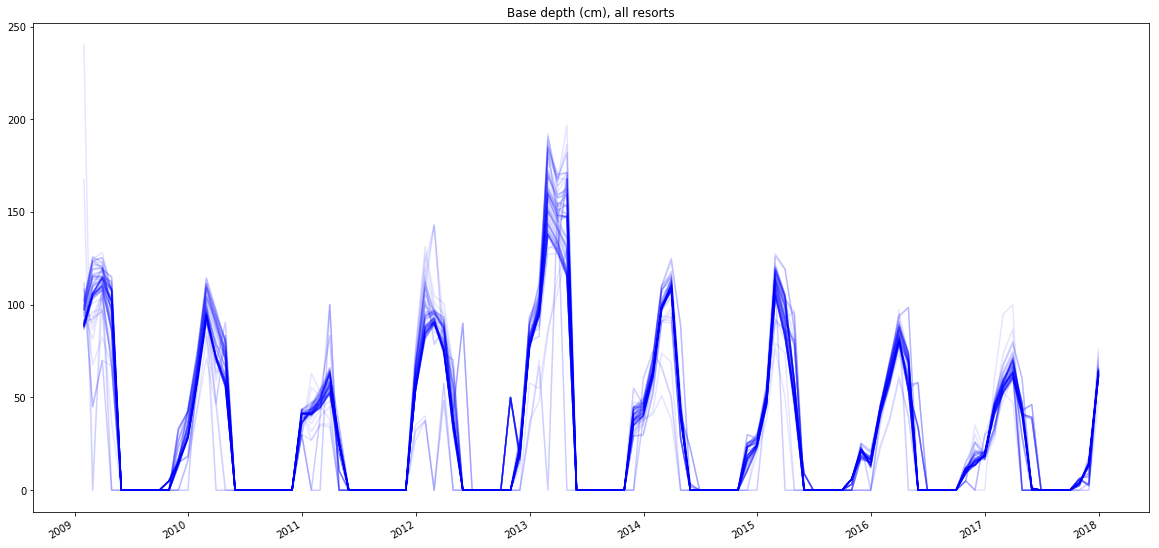

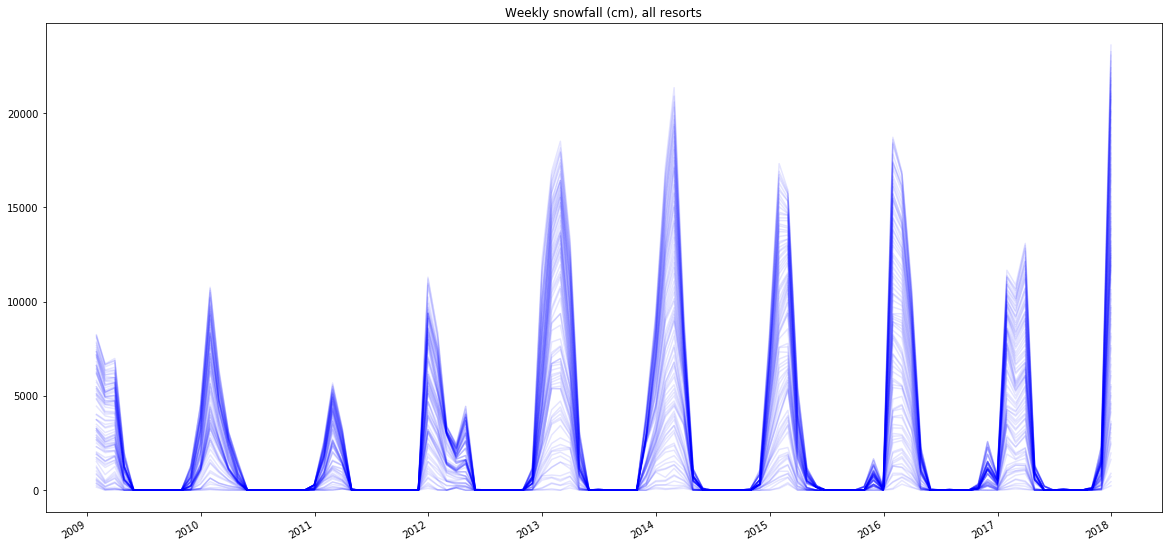

In [6]:
def PlotTimeSeries_SingleResort(tseries,title):

    fig, ax = plt.subplots(figsize=(20, 10))
    for column, series in tseries.iteritems():
        ax.plot(tseries.loc[:,column], color ='blue',alpha=0.1)
        #ax.plot(newsnow.loc[:,column], color ='blue',alpha=0.1)

    #mean = plt.plot(rolmean, color='red', label='4 week Rolling Mean')
    #std = plt.plot(rolstd, color='black', label = '4 week Rolling Standard Dev.')

    fig.autofmt_xdate()

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.title(title)
    #plt.legend()
    plt.show()

PlotTimeSeries_SingleResort(Resorts_BaseDepth,'Base depth (cm), all resorts')
PlotTimeSeries_SingleResort(Resorts_NewSnow,'Weekly snowfall (cm), all resorts')


In [7]:
def CalcMeanSD(tseries):
    Months = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
    resort=[]
    SD_df = pd.DataFrame(columns=Months)
    Mean_df = pd.DataFrame(columns=Months)


    for column, series in tseries.iteritems():
        #column = 6
        df = pd.DataFrame(tseries.loc[:,column])
        resort.append(column)
        #Index_year = pd.DataFrame(tseries.index.year)
        Index_month =  pd.DataFrame(tseries.index.month)
        #Index_year.index = pd.to_datetime(tseries.index, errors='coerce')
        Index_month.index = pd.to_datetime(tseries.index, errors='coerce')

        df = pd.concat([df,Index_month], axis=1)
        df.columns = ['resort','month']
        std =np.asarray(df.groupby(by=['month'], axis=0).std())
        mean = np.asarray(df.groupby(by=['month'], axis=0).mean())
        SD_df.loc[len(SD_df)] = std[:,0]
        Mean_df.loc[len(Mean_df)] = mean[:,0]
        SD_df.index = resort
        Mean_df.index = resort
    return SD_df, Mean_df
    

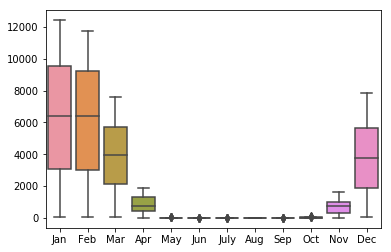

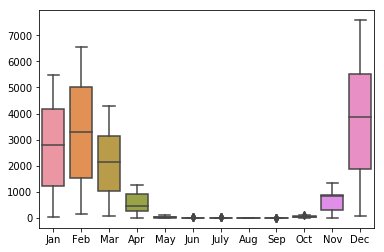

In [8]:
SD_NewSnow,Mean_NewSnow = CalcMeanSD(Resorts_NewSnow)
SD_BaseDepth,Mean_BaseDepth = CalcMeanSD(Resorts_BaseDepth)
ax = sns.boxplot(data=Mean_NewSnow)
plt.show()
ax = sns.boxplot(data=SD_NewSnow)

plt.show()

In [9]:
Months = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec']
#calculate sharpe ratios for both metrics (sharpe ratio maximises mean whilst penalising variance)
Sharpe_NewSnow =  (Mean_NewSnow - Mean_NewSnow.mean())/SD_NewSnow
Sharpe_BaseDepth =  (Mean_BaseDepth - Mean_BaseDepth.mean())/SD_BaseDepth

In [10]:
df = Sharpe_BaseDepth
df_Mean=Mean_BaseDepth
df_SD=SD_BaseDepth
def sortsharpe(df,df_Mean,df_SD):
    t=5 #select top number of values
    BestResort = pd.DataFrame(columns=Months)
    BestResort_Mean = pd.DataFrame(columns=Months)
    BestResort_SD = pd.DataFrame(columns=Months)
    #find the top 5 resports (as defined by sharpe ratio - i.e. most reliable high snowfall) and store the resort name, mean, and sd per month
    for m in Months:

        index = df.sort_values(m, ascending=False,kind ='mergesort').head(t).index
        BestResort.loc[:,m] = np.asarray(index).tolist()

        Best_Mean = df_Mean.loc[index,m]
        BestResort_Mean.loc[:,m] = np.asarray(Best_Mean).tolist()

        Best_SD = df_SD.loc[index,m]
        BestResort_SD.loc[:,m] = np.asarray(Best_SD).tolist()
    return (BestResort,BestResort_Mean,BestResort_SD)

BaseDepth_BestResort,BaseDepth_Best_Mean,BaseDepth_Best_SD = sortsharpe(Sharpe_BaseDepth,Mean_BaseDepth,SD_BaseDepth)
NewSnow_BestResort,NewSnow_Best_Mean,NewSnow_Best_SD = sortsharpe(Sharpe_NewSnow,Mean_NewSnow,SD_NewSnow)

In [55]:
months = ['Dec','Jan','Feb','Mar','Apr']
dropmonths = ['May','Jun','July','Aug','Sep','Oct','Nov']
error =BaseDepth_Best_SD.drop(labels=dropmonths,axis=1)
data = BaseDepth_Best_Mean.drop(labels=dropmonths,axis=1)
labels = BaseDepth_BestResort.drop(labels=dropmonths,axis=1)
dither =[1, 1.1, 1.9, 1.2, 0.8]
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, Whisker
nocolours = np.unique(labels[months].values).shape[0]
keys = np.unique(labels[months].values)
values =bokeh.palettes.Category20[nocolours]
colourdict = dict(zip(keys, values))

output_file("Base Snow Depth.html")

# create a new plot with a range set with a tuple
p = figure(plot_width=800, plot_height=500, x_range=(-10, 50),y_axis_label='Base snow depth (cm)',title="Top ski resorts for snow base depth by month (hover for details)",tools=[hover],)

# set a range using a Range1d
p.y_range = Range1d(0, 200)
x = 0
desc = []
for column, series in data.iteritems():
    dither =[x+1,x-2,x,x+2,x-1]
    mean = data.loc[:,column]
    sd = error.loc[:,column]
    desc=np.asarray(labels.loc[:,column]).tolist()
    lower = mean - sd
    upper = mean + sd
    colours =  [colourdict[k] for k in desc]

    source = ColumnDataSource(data=dict(x=dither,y=np.asarray(mean),desc=desc,fill_color=colours))
    p.circle('x', 'y', size=10, source=source,fill_color='fill_color')
    
    source_error = ColumnDataSource(data=dict(base=dither, lower=lower, upper=upper))

    p.add_layout(Whisker(source=source_error, base="base", upper="upper", lower="lower"))
    x=x+10
    


hover = HoverTool(tooltips=[
    ("Base snow depth:", "$y cm"),
    ("Resort:", "@desc"),
])
#x.yaxis.visible = None
p.xaxis.major_label_overrides = {-10:"",0:'Dec',10:'Jan',20:'Feb',30:'Mar',40:"Apr",50:""}
show(p)

In [56]:
months = ['Dec','Jan','Feb','Mar','Apr']
dropmonths = ['May','Jun','July','Aug','Sep','Oct','Nov']
error =NewSnow_Best_SD.drop(labels=dropmonths,axis=1)
data = NewSnow_Best_Mean.drop(labels=dropmonths,axis=1)
labels = NewSnow_BestResort.drop(labels=dropmonths,axis=1)
from bokeh.plotting import figure, output_file, show
from bokeh.models import Range1d
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, Whisker
import bokeh
nocolours = np.unique(labels[months].values).shape[0]
keys = np.unique(labels[months].values)
values =bokeh.palettes.Category20[nocolours]
colourdict = dict(zip(keys, values))


output_file("Fresh Snowfall.html")

# create a new plot with a range set with a tuple
p = figure(plot_width=800, plot_height=500, x_range=(-10, 50),y_axis_label='Monthly snowfall (m)',title="Top ski resorts for snowfall by month (hover for details)",tools=[hover],)

# set a range using a Range1d
p.y_range = Range1d(0, 200)
x = 0
desc = []
for column, series in data.iteritems():
    dither =[x+1,x-2,x,x+2,x-1]
    mean = data.loc[:,column]/100
    sd = error.loc[:,column]/100
    desc=np.asarray(labels.loc[:,column]).tolist()
    lower = mean - sd
    upper = mean + sd
    colours =  [colourdict[k] for k in desc]

    source = ColumnDataSource(data=dict(x=dither,y=np.asarray(mean),desc=desc,fill_color=colours))
    p.circle('x', 'y', size=10, source=source,fill_color='fill_color')
    source_error = ColumnDataSource(data=dict(base=dither, lower=lower, upper=upper))

    p.add_layout(Whisker(source=source_error, base="base", upper="upper", lower="lower"))
    x=x+10
    


hover = HoverTool(tooltips=[
    ("Monthly snowfall:", "$y m"),
    ("Resort:", "@desc"),
])
#x.yaxis.visible = None
p.xaxis.major_label_overrides = {-10:"",0:'Dec',10:'Jan',20:'Feb',30:'Mar',40:"Apr",50:''}
show(p)